# 영화 암살의 코멘트로 부터 단어 임베딩 하기

In [1]:
import sqlite3
import gensim
import codecs
import glob
import logging
import multiprocessing
import os
import pprint as pp
import re
import nltk
import gensim.models.word2vec as w2v
import sklearn.manifold
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
%pylab inline

C:\Users\smilemango\Anaconda3\envs\tensorflow\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


Populating the interactive namespace from numpy and matplotlib


## DB에 저장된 코멘트에서 하정우, 전지현, 이정재 라는 단어가 들어간 문장만 추출해온다.
추출해온 문장의 수가 440개로 적은 편이므로 똑같은 문장을 20번 반복하여 8,800 개의 문장으로 늘려준다.

In [2]:
conn = sqlite3.connect('movies.sqlite')
c = conn.cursor()
# SQL 쿼리 실행
c.execute("""select movie_id, comment_id, rate, replace(comment, ',',' ')
from comments 
where 
     replace(comment, ',',' ') like '%전지현 %' 
and  replace(comment, ',',' ') like '%하정우 %'
and  replace(comment, ',',' ') like '%이정재 %'
union all
select * from comments 
where 
    comment like '%전지현 %' 
and comment like '%하정우 %'
and comment like '%이정재 %'
""")

# 데이타 Fetch
rows = c.fetchall()
sentences = []
idx = 0
for a_row in rows:
    words = a_row[3].split()
    sentences.append(words)
print("[1] SENTENSE SIZE : %d " %  len(sentences) )
sentences = sentences * 20
print("[2] SENTENSE SIZE : %d " %  len(sentences) )

[1] SENTENSE SIZE : 440 
[2] SENTENSE SIZE : 8800 


# 모델 만들기 

위에서 추출한 문장을 넣어서 모델을 훈련시킨다.

In [4]:
num_features = 300
min_word_count = 3
num_workers = multiprocessing.cpu_count()
context_size = 7
downsampling = 1e-3
seed = 1
model = gensim.models.Word2Vec(
    sg=1,seed=seed,workers=num_workers,size=num_features,
    min_count=min_word_count,window=context_size,sample=downsampling)
model.build_vocab(sentences)
print("Word2Vec vocabulary length:", len(model.wv.vocab))

model.train(sentences,total_examples=model.corpus_count, epochs=model.iter)
print("corpus_count:%d"% model.corpus_count)
print("epochs:%d"% model.iter)

2017-05-11 21:59:45,443 : INFO : collecting all words and their counts
2017-05-11 21:59:45,446 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2017-05-11 21:59:45,481 : INFO : collected 1924 word types from a corpus of 124680 raw words and 8800 sentences
2017-05-11 21:59:45,483 : INFO : Loading a fresh vocabulary
2017-05-11 21:59:45,492 : INFO : min_count=3 retains 1924 unique words (100% of original 1924, drops 0)
2017-05-11 21:59:45,496 : INFO : min_count=3 leaves 124680 word corpus (100% of original 124680, drops 0)
2017-05-11 21:59:45,516 : INFO : deleting the raw counts dictionary of 1924 items
2017-05-11 21:59:45,525 : INFO : sample=0.001 downsamples 27 most-common words
2017-05-11 21:59:45,533 : INFO : downsampling leaves estimated 95730 word corpus (76.8% of prior 124680)
2017-05-11 21:59:45,541 : INFO : estimated required memory for 1924 words and 300 dimensions: 5579600 bytes
2017-05-11 21:59:45,567 : INFO : resetting layer weights
2017-05-11 21:59:

Word2Vec vocabulary length: 1924


2017-05-11 21:59:46,618 : INFO : worker thread finished; awaiting finish of 7 more threads
2017-05-11 21:59:46,620 : INFO : worker thread finished; awaiting finish of 6 more threads
2017-05-11 21:59:46,657 : INFO : PROGRESS: at 92.95% examples, 437519 words/s, in_qsize 5, out_qsize 1
2017-05-11 21:59:46,665 : INFO : worker thread finished; awaiting finish of 5 more threads
2017-05-11 21:59:46,685 : INFO : worker thread finished; awaiting finish of 4 more threads
2017-05-11 21:59:46,690 : INFO : worker thread finished; awaiting finish of 3 more threads
2017-05-11 21:59:46,744 : INFO : worker thread finished; awaiting finish of 2 more threads
2017-05-11 21:59:46,756 : INFO : worker thread finished; awaiting finish of 1 more threads
2017-05-11 21:59:46,760 : INFO : worker thread finished; awaiting finish of 0 more threads
2017-05-11 21:59:46,765 : INFO : training on 623400 raw words (478733 effective words) took 1.1s, 425226 effective words/s
2017-05-11 21:59:46,773 : WARNING : under 10 j

corpus_count:8800
epochs:5


# 모델 시각화 하기
소스를 베껴온거라 스터디가 필요하다. 

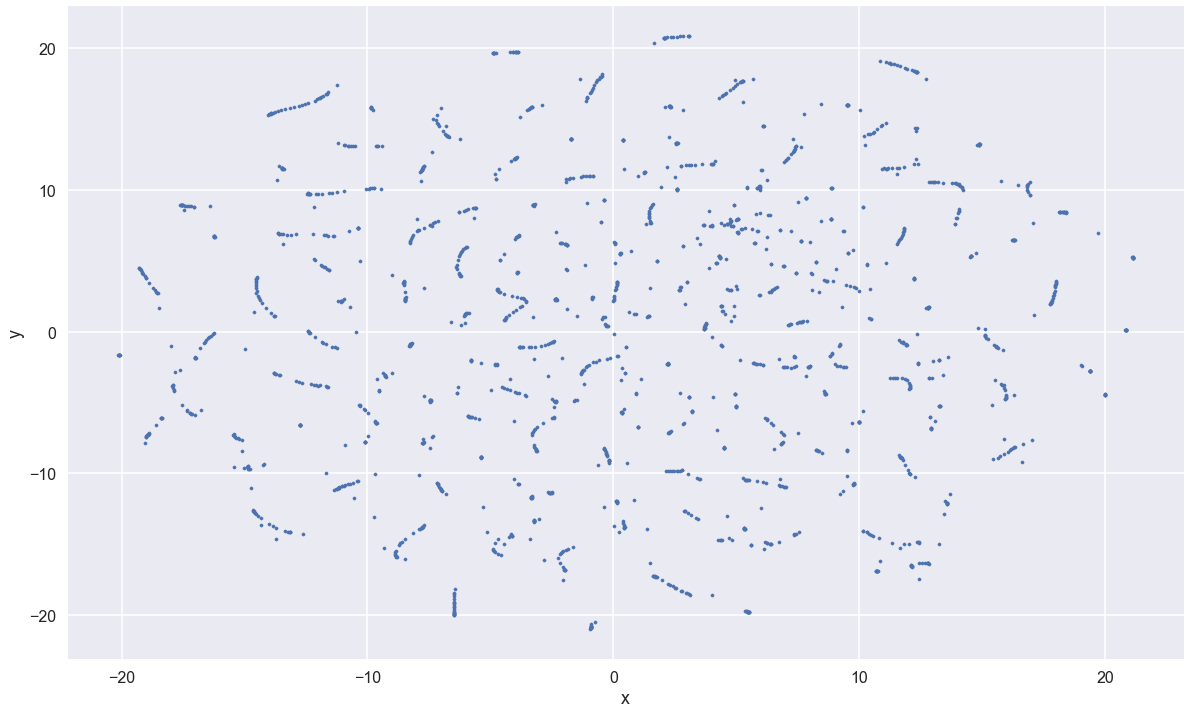

In [5]:
#my video - how to visualize a dataset easily
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)

all_word_vectors_matrix = model.wv.syn0
model.wv.syn0[0]

all_word_vectors_matrix_2d = tsne.fit_transform(all_word_vectors_matrix)
points = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, all_word_vectors_matrix_2d[model.wv.vocab[word].index])
            for word in model.wv.vocab
        ]
    ],
    columns=["word", "x", "y"]
)
points.head(10)
sns.set_context("poster")
points.plot.scatter("x", "y", s=10, figsize=(20, 12))

# 하정우의 위치 찾기
모든 문장에 전지현, 하정우, 이정재가 들어가 있기 때문에, 세 단어간의 관계는 긴밀할 것이고, 거리상으로 가까울 거라 추정된다.
그러므로, 하정우의 위치 먼저 확인한다.

In [6]:
for value in points.values:
    if value[0] =='하정우':
        print(value)

['하정우' 6.364168933483107 8.237871104746233]


In [7]:
#부분 확대를 위한 함수 선언
def plot_region(x_bounds, y_bounds):
    slice = points[
        (x_bounds[0] <= points.x) &
        (points.x <= x_bounds[1]) & 
        (y_bounds[0] <= points.y) &
        (points.y <= y_bounds[1])
    ]
    
    ax = slice.plot.scatter("x", "y", s=35, figsize=(10, 8))
    for i, point in slice.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)
#한글 표기를 위한 설정
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)        

# 하정우, 전지현, 이정재 위치 확인
아래와 같이 세개는 거의 비슷한 위치에 있다. 다른 단어간의 관계는 좀더 파악을 해봐야 할것 같다.

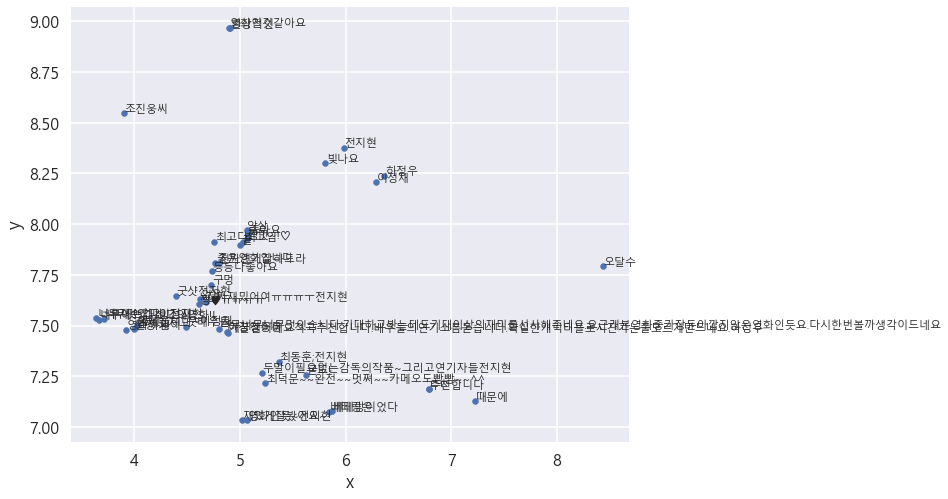

In [21]:
plot_region(x_bounds=(2, 8.5), y_bounds=(7, 9))

# 수치로 관계확인
아래와 같이 이정재, 전지현, 하정우의 관계가 가장 밀접하다.

In [23]:
model.most_similar("이정재")

[('하정우', 0.6079907417297363),
 ('전지현', 0.549247682094574),
 ('없음..', 0.45671695470809937),
 ('최고다', 0.44341936707496643),
 ('진짜연기잘하드라', 0.4230274558067322),
 ('짱♥ㅠㅠㅠㅠ', 0.42283719778060913),
 ('진짜재밌어여ㅠㅠㅠㅜ전지현', 0.41523975133895874),
 ('베테랑이었다', 0.4125989079475403),
 ('굿배우들', 0.41063931584358215),
 ('연출력', 0.4100826382637024)]

In [24]:
model.most_similar("전지현")

[('이정재', 0.549247682094574),
 ('하정우', 0.5436713695526123),
 ('없음..', 0.4520094096660614),
 ('진짜연기잘하드라', 0.4318196177482605),
 ('등등다좋아요', 0.41807103157043457),
 ('변함없는', 0.41754937171936035),
 ('짱♥ㅠㅠㅠㅠ', 0.41307246685028076),
 ('너무너무너무멋잇습니다.기대하고봣는데도기대이상의재미를선사해주네요.요근래본영화중가장돈아깝지않은영화인듯요.다시한번볼까생각이드네요',
  0.41255274415016174),
 ('최고다', 0.4061759114265442),
 ('조선명탐정의', 0.39935752749443054)]

In [25]:
model.most_similar("하정우")

[('이정재', 0.6079908609390259),
 ('전지현', 0.5436714887619019),
 ('짱♥ㅠㅠㅠㅠ', 0.435976505279541),
 ('진짜연기잘하드라', 0.43367668986320496),
 ('없음..', 0.42944076657295227),
 ('진짜재밌어여ㅠㅠㅠㅜ전지현', 0.4121628999710083),
 ('최고다', 0.41055503487586975),
 ('굿배우들', 0.4032030701637268),
 ('베테랑이었다', 0.39306044578552246),
 ('등등다좋아요', 0.39277198910713196)]

In [26]:
model.most_similar("조승우")

[('조진웅씨', 0.8758886456489563),
 ('김해숙인데..', 0.8351548314094543),
 ('연기력은깔게있겠나ㅋ', 0.8222543001174927),
 ('재미있었습니다.', 0.8084064722061157),
 ('하후', 0.8076728582382202),
 ('멋지십니다.', 0.8076562881469727),
 ('겁나몰입해서보고옴.', 0.8072329163551331),
 ('상당히', 0.8026795387268066),
 ('기대전혀안하고갔다가', 0.7947902679443359),
 ('이경영부인역', 0.7936381101608276)]